In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
#* magic to add python path to notebook environment
import sys
pypath = sys.path[0]
%env PYTHONPATH $pypath

from apps import cex_toy_generator, cex_toy_parameters
from IPython.display import clear_output
from python.analysis import cross_section, Plots
from statsmodels.stats.weightstats import ztest as ztest

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rich import print
cross_section.SetPlotStyle(True, 100)


@cross_section.Master.timer
def CreateObservedInputData(toy : cross_section.Toy, bins : np.array, alt_regions : pd.DataFrame = None):
    toy_observed_binned = []

    reco_regions = toy.df.filter(regex = "reco_regions") if alt_regions is None else alt_regions.columns 

    for c in reco_regions:
        m = toy.df[c] if alt_regions is None else alt_regions[c]
        toy_observed_binned.append(np.histogram(toy.df.KE_int_smeared[m], bins = bins)[0])
    return toy_observed_binned


def RegionFitStudy(toy : cross_section.Toy, model : cross_section.pyhf.Model, bins : np.array, alt_regions : pd.DataFrame = None, pdf : Plots.PlotBook = None):
    observed = cross_section.BackgroundFit.GenerateObservations(CreateObservedInputData(toy, bins, alt_regions), model)
    result = cross_section.BackgroundFit.Fit(observed, model, False)

    # prefit_pred = cross_section.cabinetry.model_utils.prediction(model)
    postfit_pred = cross_section.cabinetry.model_utils.prediction(model, fit_results = result)

    total_count_err = np.sum(np.power(postfit_pred.total_stdev_model_channels, 2))**0.5
    total_count = np.sum(postfit_pred.model_yields)
    # total_count_actual = np.sum(prefit_pred.model_yields)
    total_count_actual = sum((toy.df.inclusive_process != "decay") & (toy.df.KE_int_smeared > min(bins)) & (toy.df.KE_int_smeared < max(bins)))


    print(f"{total_count_actual, total_count, total_count_err=}")

    # Plot fitted correlation matrix and actual
    plot = Plots.MultiPlot(2)
    next(plot)
    truth_regions_masksed = {t : toy.truth_regions[t] & (((toy.df.KE_int_smeared) > min(bins)) & ((toy.df.KE_int_smeared) < max(bins))) for t in toy.truth_regions}
    reco_regions_masksed = {r : toy.reco_regions[r] & (((toy.df.KE_int_smeared) > min(bins)) & ((toy.df.KE_int_smeared) < max(bins))) for r in toy.reco_regions} 
    counts_matrix = cross_section.Toy.ComputeCounts(truth_regions_masksed, reco_regions_masksed)
    cex_toy_parameters.PlotCorrelationMatrix(counts_matrix, toy.truth_region_labels, toy.reco_region_labels, title = "actual", newFigure = False)
    next(plot)
    counts_matrix = []
    for c in postfit_pred.model_yields:
        counts_matrix.append([sum(s) for s in c])
    counts_matrix = np.array(counts_matrix, dtype = int).T
    cex_toy_parameters.PlotCorrelationMatrix(counts_matrix, toy.truth_region_labels, toy.reco_region_labels, title = "fitted", newFigure = False)

    if pdf is not None: pdf.Save()

    mu = {}
    for n in model.config.par_names:
        if "mu" in n:
            mu[f"${n}$"] = {"value" : result.bestfit[model.config.par_names.index(n)], "error" : result.uncertainty[model.config.par_names.index(n)]}
    mu = pd.DataFrame(mu)

    # Plot parameters of interest
    Plots.Plot(list(mu.columns), mu.iloc[0], yerr = mu.iloc[1], marker = "o", linestyle = "")
    Plots.plt.xticks(ticks = list(mu.columns), labels = list(mu.columns))
    if pdf is not None: pdf.Save()

    # Plot all fit parameters
    Plots.Plot(np.linspace(0, len(result.bestfit), len(result.bestfit)), result.bestfit, yerr = result.uncertainty, linestyle = "", marker = "o", markersize = 1, capsize = 2, xlabel = "fit parameter index", ylabel = "value")
    plt.ylim(0.75, 1.25)
    if pdf is not None: pdf.Save()

    # print table of parameters of interest
    print(mu.head())
    return result


def MLEScan(toy, model, bins, poi_ind : int, params : np.array):
    observations = cross_section.BackgroundFit.GenerateObservations(CreateObservedInputData(toy, bins), model)
    mu = np.linspace(0, 2, 101)
    nll = []
    for m in mu:
        params_new = np.array(params)
        params_new[poi_ind] = m
        nll.append(-2 * model.logpdf(params_new, observations)[0])

    Plots.Plot(mu, nll, xlabel = f"$\mu_{poi_ind}$", ylabel = "$-2\ln(L)$", newFigure = False)
    min_ind = np.argmin(nll)
    Plots.Plot(mu[min_ind], nll[min_ind], marker = "x", newFigure = False, label = f"minimum | $\mu_{poi_ind}$={mu[min_ind]:.3g}, $-2\ln(L)$={nll[min_ind]:.3g}", color = "black")


def CreateModelInputData(toy : cross_section.Toy, bins : np.array):
    model_input_data = []
    for c in toy.df.filter(regex = "reco_regions"):
        tmp = []
        for s in toy.df.filter(regex = "truth_regions"):
            tmp.append(np.histogram(toy.df.KE_int_smeared[toy.df[c] & toy.df[s]], bins = bins)[0])
        model_input_data.append(tmp)
    return model_input_data


class Pulls:
    def __init__(self, toy : cross_section.Toy, model : cross_section.pyhf.Model, bins : np.array) -> None:
        self.toy = toy
        self.model = model
        self.bins = bins
        pass

    def ComputePulls(self) -> np.array:

        true_process_counts_model = np.sum(np.sum(cross_section.cabinetry.model_utils.prediction(self.model).model_yields, 2), 0)
        true_process_counts_model = {k : true_process_counts_model[i] for i, k in enumerate(self.toy.truth_region_labels)}

        mask = (self.toy.df.inclusive_process != "decay") & (self.toy.df.KE_int_smeared > min(self.bins)) & (self.toy.df.KE_int_smeared < max(self.bins))
        expected = [sum(self.toy.truth_regions[r] & mask) / true_process_counts_model[r] for r in self.toy.truth_region_labels]

        observed = cross_section.BackgroundFit.GenerateObservations(CreateObservedInputData(self.toy, self.bins), self.model)
        try:
            result = cross_section.BackgroundFit.Fit(observed, self.model, False)
        except:
            return observed
        unconstrained_params = [self.model.config.par_slice(i).start for i in self.model.config.par_names if "mu" in i]

        pull = (np.array(result.bestfit[unconstrained_params]) - expected) / np.array(result.uncertainty[unconstrained_params])
        return pull


def CalculatePulls(n : int, config : dict, model : cross_section.pyhf.Model, bins : np.array):
    def Run(toy : cross_section.Toy):
        puller = Pulls(toy, model, bins)
        clear_output()
        return puller.ComputePulls()

    config_pulls = {k : v for k, v in config.items()}
    # config_pulls["events"] = config_pulls["events"] * n

    pool = cex_toy_generator.ProcessPool(nodes = 10)
    workers = []
    for i in range(n):
        # tmp_toy = cross_section.Toy(df = toy_config.iloc[i * events: (i + 1) * events], smearing = True)
        tmp_toy = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(config_pulls)), smearing = True)
        clear_output()
        workers.append(pool.apipe(Run, tmp_toy))
    results = [worker.get() for worker in workers]
    pool.clear()
    pool.restart()
    return np.array(results)


def StudyPulls(theta : np.array):
    metrics = []
    for i in range(theta.shape[1]):
        metric = {}
        metric["mu"] = np.mean(theta[:, i])
        metric["sigma"] = np.std(theta[:, i])
        metric["z"], metric["p"] = ztest(theta[:, i], value = 0)
        metrics.append(metric)

    print(pd.DataFrame(metrics, index = [f"$\mu_{i}$" for i in range(theta.shape[1])]).style.to_latex())

    for i in Plots.MultiPlot(theta.shape[1]):
        z, p = ztest(theta[:, i], value = 0)
        Plots.PlotHist(theta[:, i], bins = 15, title = f"$\mu$:{np.mean(theta[:, i]):.3g}, $\sigma$:{np.std(theta[:, i]):.3g}, $z$:{z:.3g}, $p$:{p:.3g}", xlabel = f"$\mu_{i}$ pulls", newFigure = False)
    return


env: PYTHONPATH=/home/sb16165/Documents/pi0-analysis/analysis


In [2]:
toy_input = cross_section.Toy(file = "work/2023/toys/xs_toy_1GeV_gaussian_60MeV_fit_input.hdf5", smearing = True)
energy_slice = cross_section.Slices(50, 0, 1050, True)
bins = np.sort(energy_slice.pos)
model = cross_section.BackgroundFit.CreateModel(4, CreateModelInputData(toy_input, bins), mc_stat_unc = True)
cross_section.BackgroundFit.PrintModelSpecs(model)

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 21, 'channel_1': 21, 'channel_2': 21, 'channel_3': 21}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'normfactor'), ('mu_3', 'normfactor'), ('sample_0_pois_err_0', 'shapesys'), ('sample_0_pois_err_1', 'shapesys'), ('sample_0_pois_err_2', 'shapesys'), ('sample_0_pois_err_3', 'shapesys'), ('sample_1_pois_err_0', 'shapesys'), ('sample_1_pois_err_1', 'shapesys'), ('sample_1_pois_err_2', 'shapesys'), ('sample_1_pois_err_3', 'shapesys'), ('sample_2_pois_err_0', 'shapesys'), ('sample_2_pois_err_1', 'shapesys'), ('sample_2_pois_err_2', 'shapesys'), ('sample_2_pois_err_3', 'shapesys'), ('sample_3_pois_err_0', 'shapesys'), ('sample_3_pois_err_1', 'shapesys'), ('sample_3_pois_err_2', 'shapesys'), ('sample_3_pois_err_3', 'shapesys')]
parameters: ['mu_0', 'mu_1', 'mu_2', 'mu_3', 'sample_0_pois_err_0', 'sample_0_pois_err_1', '

# Validation test

'CreateObservedInputData' executed in 0.7104s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

total_count_actual, total_count, total_count_err=(9850137, 9850137.000000004, 12512.63525100085)

$mu_0$    $mu_1$    $mu_2$    $mu_3$
value  1.000000  1.000000  1.000000  1.000000
error  0.002722  0.004337  0.002665  0.006522

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:887: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


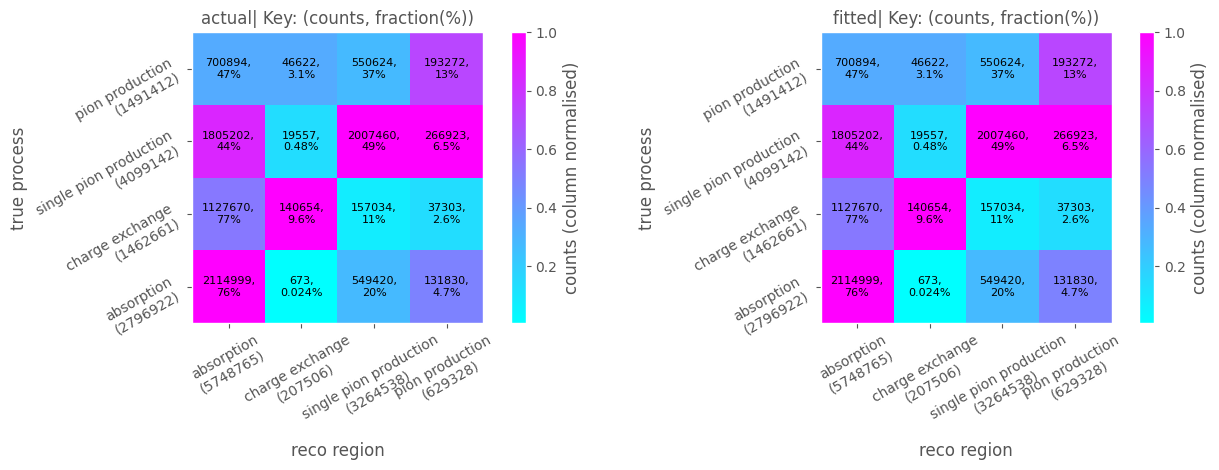

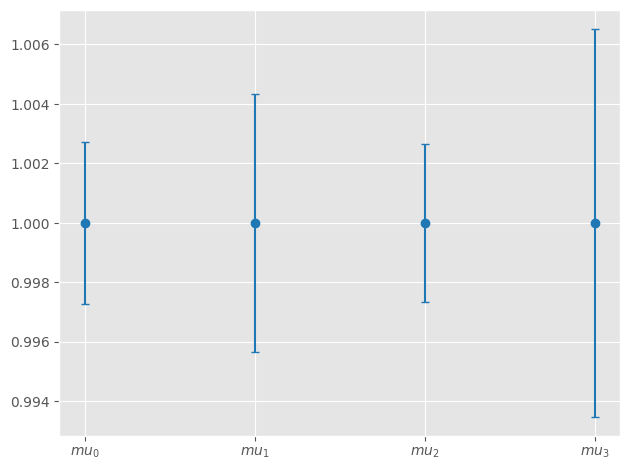

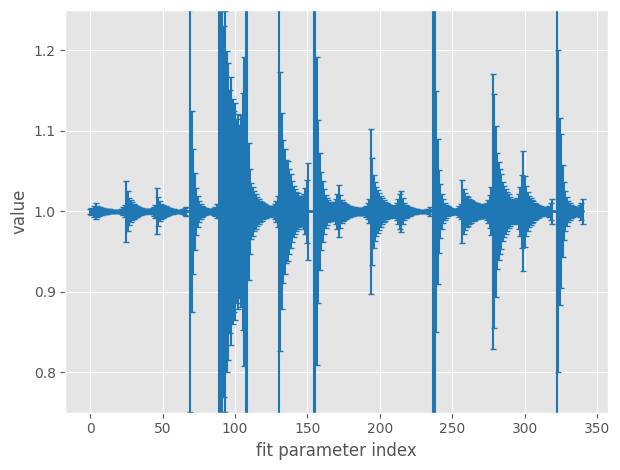

In [3]:
pdf = Plots.PlotBook("toy_validation_fit", False)
result = RegionFitStudy(toy_input, model, bins, pdf = pdf)
pdf.close()

# ProtoDUNE MC Stats

In [13]:
toy_PDSP_1GeV_config = {
    "events" : 50805,
    "step" : 2,
    "p_init" : 1000,
    "beam_profile" : "gaussian",
    "beam_width" : 60,

    "smearing_params" : {
        "KE_init" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_ff_resolution.json",
        "KE_int" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_int_resolution.json",
        "z_int" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/track_length_resolution.json"
    },
    "reco_region_fractions" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/reco_regions/reco_region_fractions.hdf5",
    "beam_selection_efficiencies" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/pi_beam_efficiency/beam_selection_efficiencies_true.hdf5",
    "pdf_scale_factors" : None,
    "verbose" : False
}

In [14]:
pulls = CalculatePulls(1000, toy_PDSP_1GeV_config, model, bins)

'CreateObservedInputData' executed in 0.0052s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

\begin{tabular}{lrrrr}
 & mu & sigma & z & p \\
$\mu_0$ & 0.047980 & 0.948314 & 1.595136 & 0.110682 \\
$\mu_1$ & -0.170613 & 0.961879 & -5.592244 & 0.000000 \\
$\mu_2$ & -0.059762 & 0.991017 & -1.901246 & 0.057270 \\
$\mu_3$ & 0.131750 & 1.005575 & 4.130761 & 0.000036 \\
\end{tabular}

'\n\x08egin{tabular}{lrrrr}\n & mu & sigma & z & p \\\n$\\mu_0$ & -0.066247 & 0.940847 & -1.404719 & 0.160105 \\\n$\\mu_1$ & -0.208070 & 0.987476 & -4.203626 & 0.000026 \\\n$\\mu_2$ & -0.293601 & 0.924715 & -6.334188 & 0.000000 \\\n$\\mu_3$ & 0.501807 & 0.967053 & 10.352077 & 0.000000 \\\n\\end{tabular}\n'

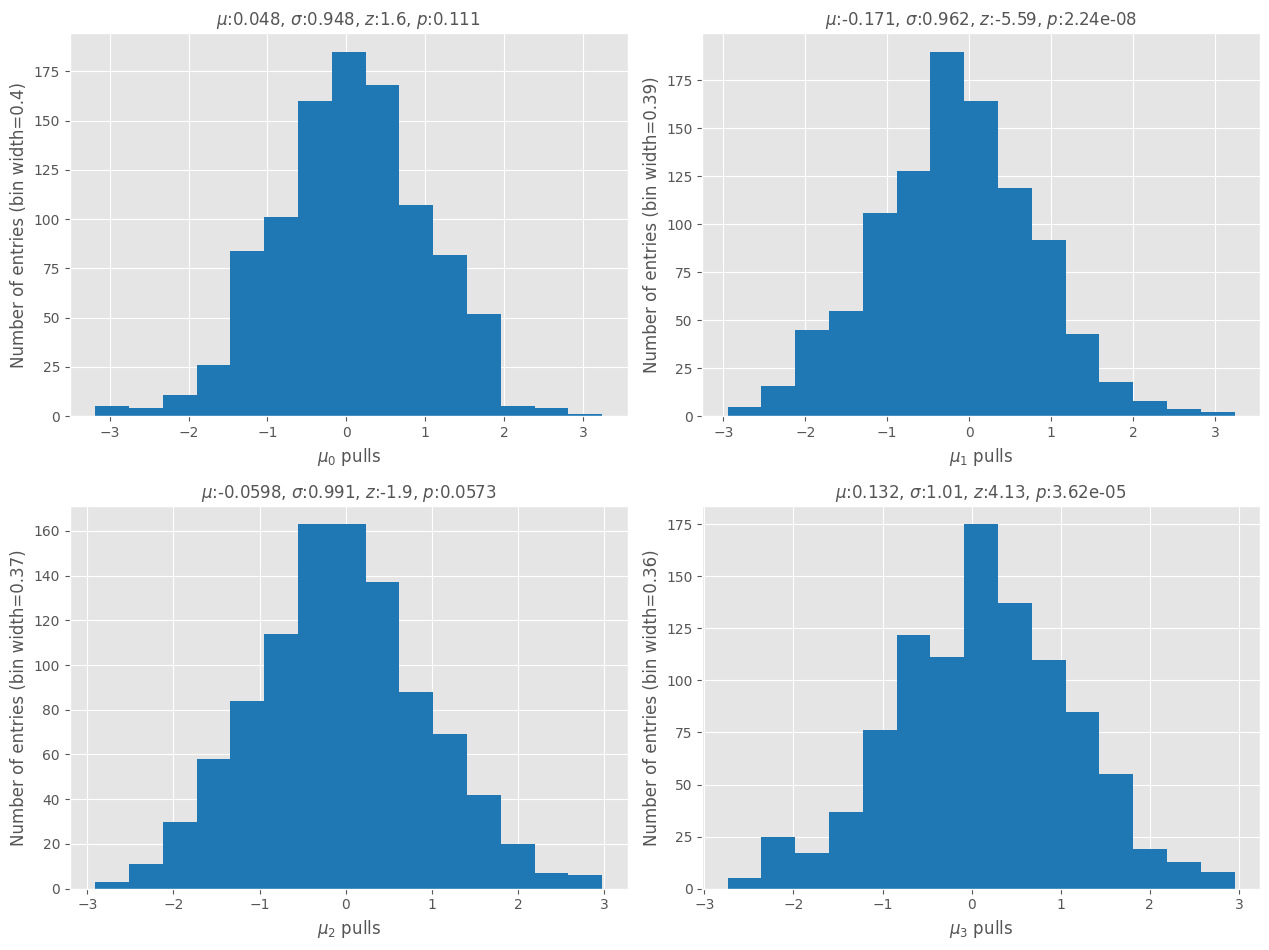

In [16]:
pulls = np.array([p for p in pulls if len(p) == 4])
StudyPulls(pulls)

"""

"""

In [53]:
toy_observed = cex_toy_generator.main(cex_toy_generator.ResolveConfig(toy_PDSP_1GeV_config))

starting batch : 0, cpus : 1

Done! Creating dataframe...

total_inelastic 50493

decay 312

charge_exchange 7418

absorption 14463

quasielastic 18326

pion_production 7671

double_charge_exchange 2615

312

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Fitting.py:245: RuntimeWarning: invalid value encountered in power
  E1 = A * (B-z)**(-p4)
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Fitting.py:246: RuntimeWarning: invalid value encountered in power
  E2 = C * (D+z)**(-p6)


'Smearing' executed in 0.1100s

'BeamSelectionEfficiency' executed in 0.0036s

'GenerateRecoRegions' executed in 0.0523s

'main' executed in 5.6311s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

total_count_actual, total_count, total_count_err=(9850137.0, 50093.22590311484, 705.1827028600267)

$\mu_0$   $\mu_1$   $\mu_2$   $\mu_3$
value  0.004886  0.005322  0.005371  0.004443
error  0.000148  0.000237  0.000149  0.000365

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:887: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


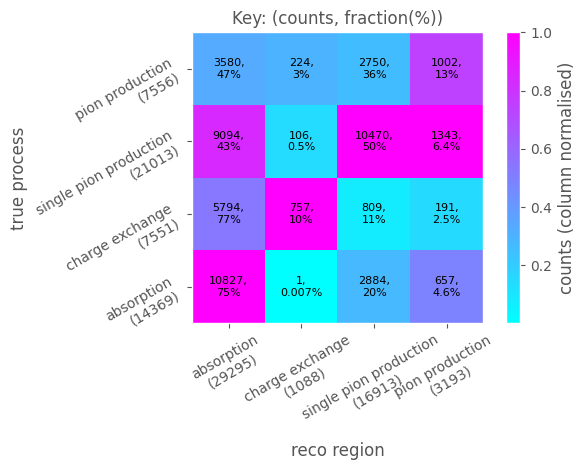

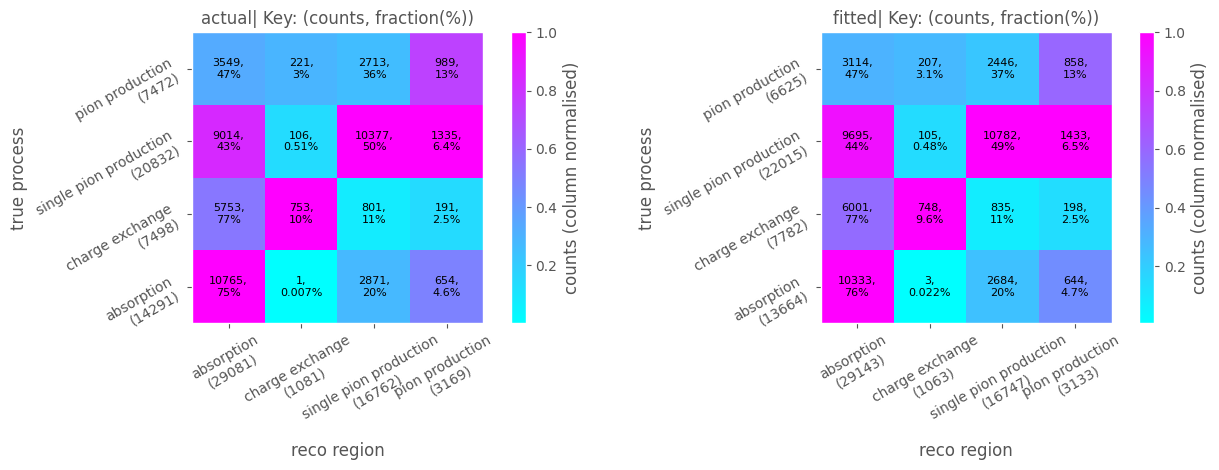

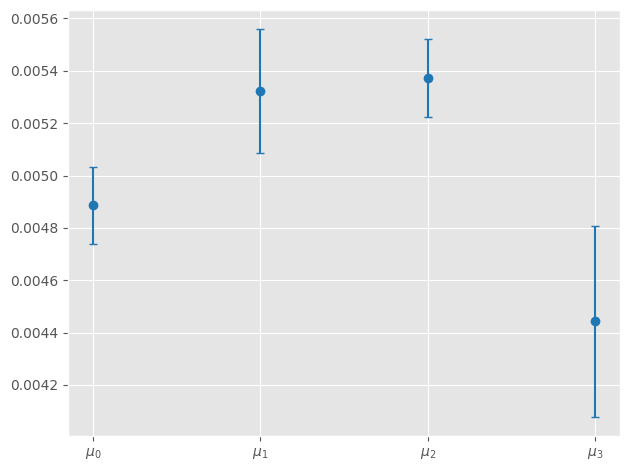

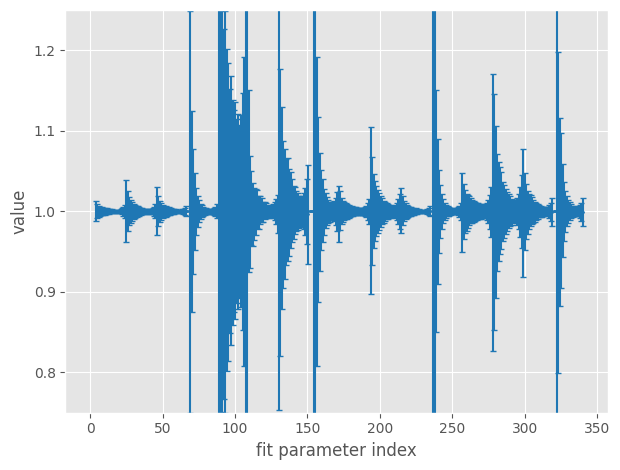

In [50]:
toy_observed = cross_section.Toy(df = toy_observed, smearing = True)
true_counts = cross_section.Toy.ComputeCounts(toy_observed.truth_regions, toy_observed.reco_regions)
cex_toy_parameters.PlotCorrelationMatrix(true_counts, toy_observed.truth_region_labels, toy_observed.reco_region_labels)

pdf_low_stats = Plots.PlotBook("toy_fit_low_stats.pdf", False)
result = RegionFitStudy(toy_observed, model, bins, pdf = pdf_low_stats)
pdf_low_stats.close()

# Alternate correlation matrix

In [ ]:
toy_alt = cross_section.Toy("work/2023/toys/xs_toy_1GeV_gaussian_60MeV_fit_input.hdf5", True)
fractions = pd.read_hdf("work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/reco_regions/reco_region_fractions.hdf5")

print(fractions)

fractions["pion_production"]["pion_production"] += 0.25
fractions["pion_production"]["single_pion_production"] -= 0.25

# fractions["charge_exchange"]["charge_exchange"] += 0.1
# fractions["charge_exchange"]["absorption"] -= 0.1


print(fractions)

regions = cex_toy_generator.GenerateRecoRegions(toy_input.df.exclusive_process, fractions)

toy_alt._Toy__reco_regions = cross_section.Toy.GetRegion(regions, "reco_regions_")
toy_alt._Toy__truth_regions = cross_section.Toy.GetRegion(regions, "truth_regions_")


In [ ]:
pdf = Plots.PlotBook("toy_vary_regions.pdf", False)
cross_section.Toy.PlotObservablesInRegions(toy_alt.df.KE_int_smeared, toy_alt.reco_regions, toy_alt.truth_regions, "$KE_{int} (MeV)$", stacked = True, histtype = "stepfilled", pdf = pdf)
result = RegionFitStudy(toy_alt, model, bins, toy_alt.reco_regions, pdf = pdf)
pdf.close()

# Modified exclusive process rates

In [3]:
def CreateConfig(scales : dict):
    return {
    "events" : 50805,
    "step" : 2,
    "p_init" : 1000,
    "beam_profile" : "gaussian",
    "beam_width" : 60,

    "smearing_params" : {
        "KE_init" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_ff_resolution.json",
        "KE_int" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_int_resolution.json",
        "z_int" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/track_length_resolution.json"
    },
    "reco_region_fractions" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/reco_regions/reco_region_fractions.hdf5",
    "beam_selection_efficiencies" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/pi_beam_efficiency/beam_selection_efficiencies_true.hdf5",
    "pdf_scale_factors" : scales,
    "verbose" : False
    }

scales = {
    'absorption': 1,
    'quasielastic': 1,
    'charge_exchange': 2,
    'double_charge_exchange': 1,
    'pion_production': 1
    }


## original PDFs

'Simulate' executed in 4.8261s

'Smearing' executed in 0.0733s

'BeamSelectionEfficiency' executed in 0.0028s

'GenerateRecoRegions' executed in 0.0441s

'main' executed in 5.0355s

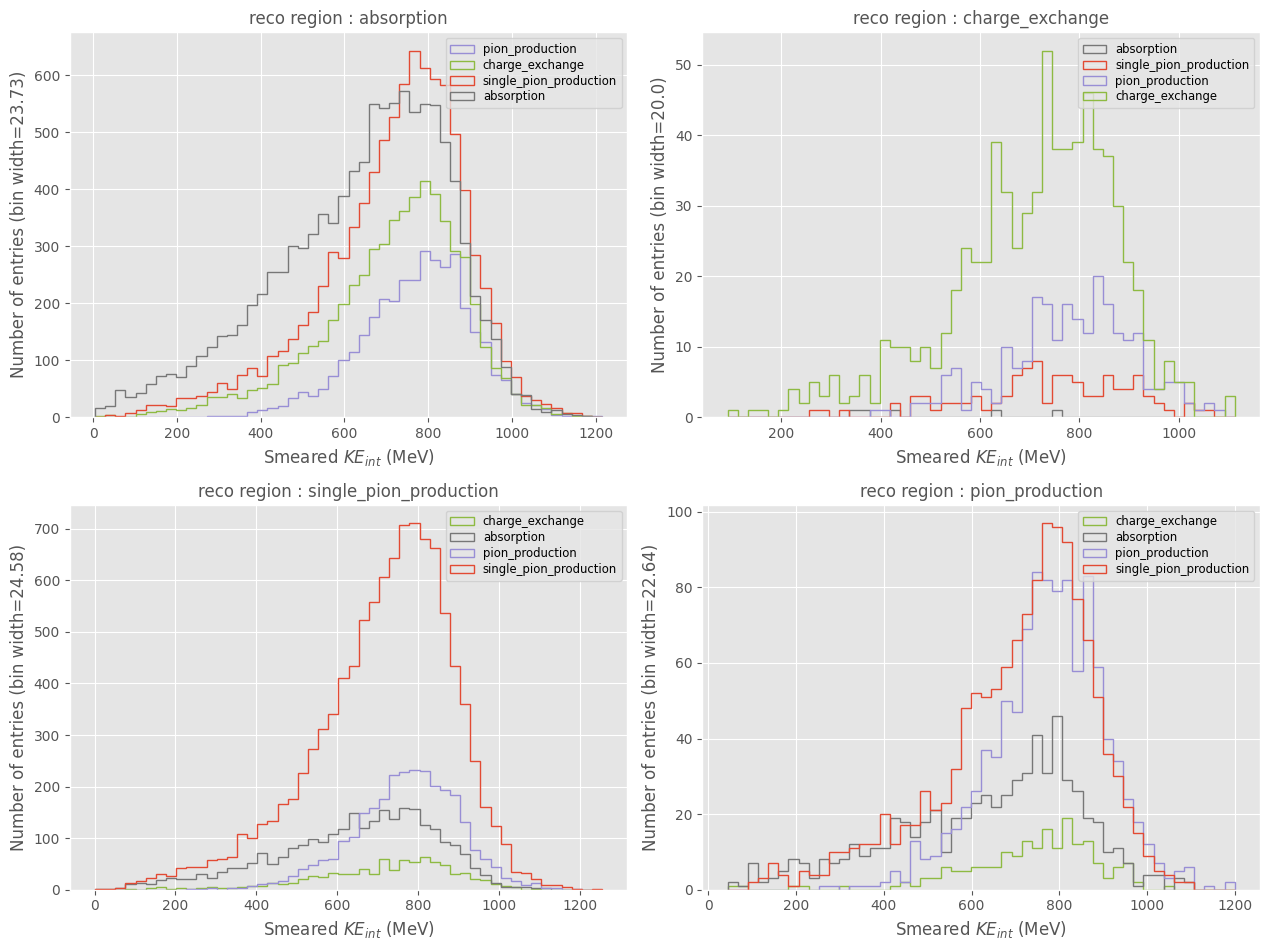

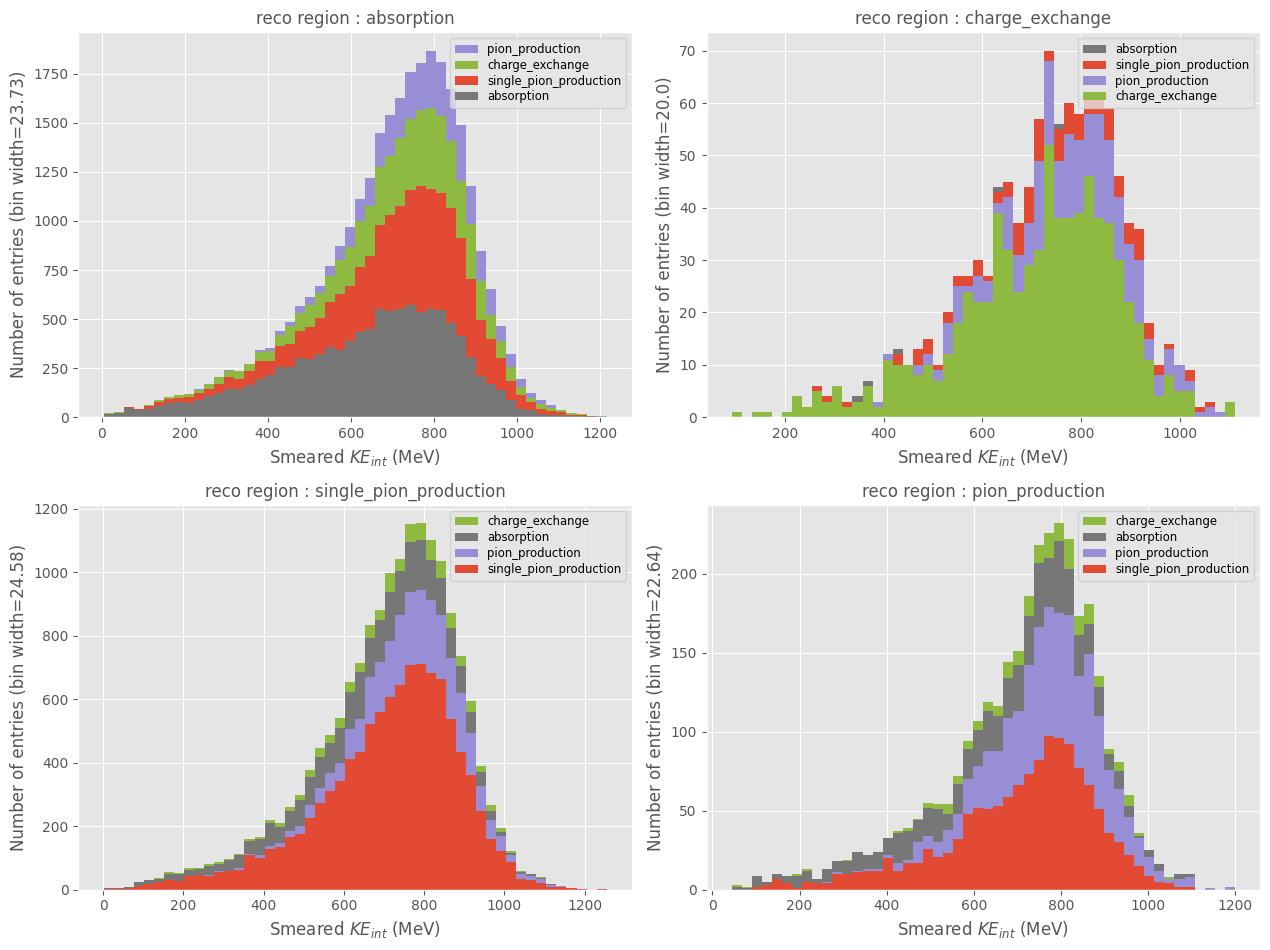

In [22]:
toy_alt_pdf = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(toy_PDSP_1GeV_config)), smearing = True)
cross_section.Toy.PlotObservablesInRegions(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.reco_regions, toy_alt_pdf.truth_regions, "Smeared $KE_{int}$ (MeV)")
cross_section.Toy.PlotObservablesInRegions(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.reco_regions, toy_alt_pdf.truth_regions, "Smeared $KE_{int}$ (MeV)", stacked = True, histtype = "stepfilled")

## modified PDFs

'Simulate' executed in 4.8721s

'Smearing' executed in 0.0745s

'BeamSelectionEfficiency' executed in 0.0028s

'GenerateRecoRegions' executed in 0.0430s

'main' executed in 5.0828s

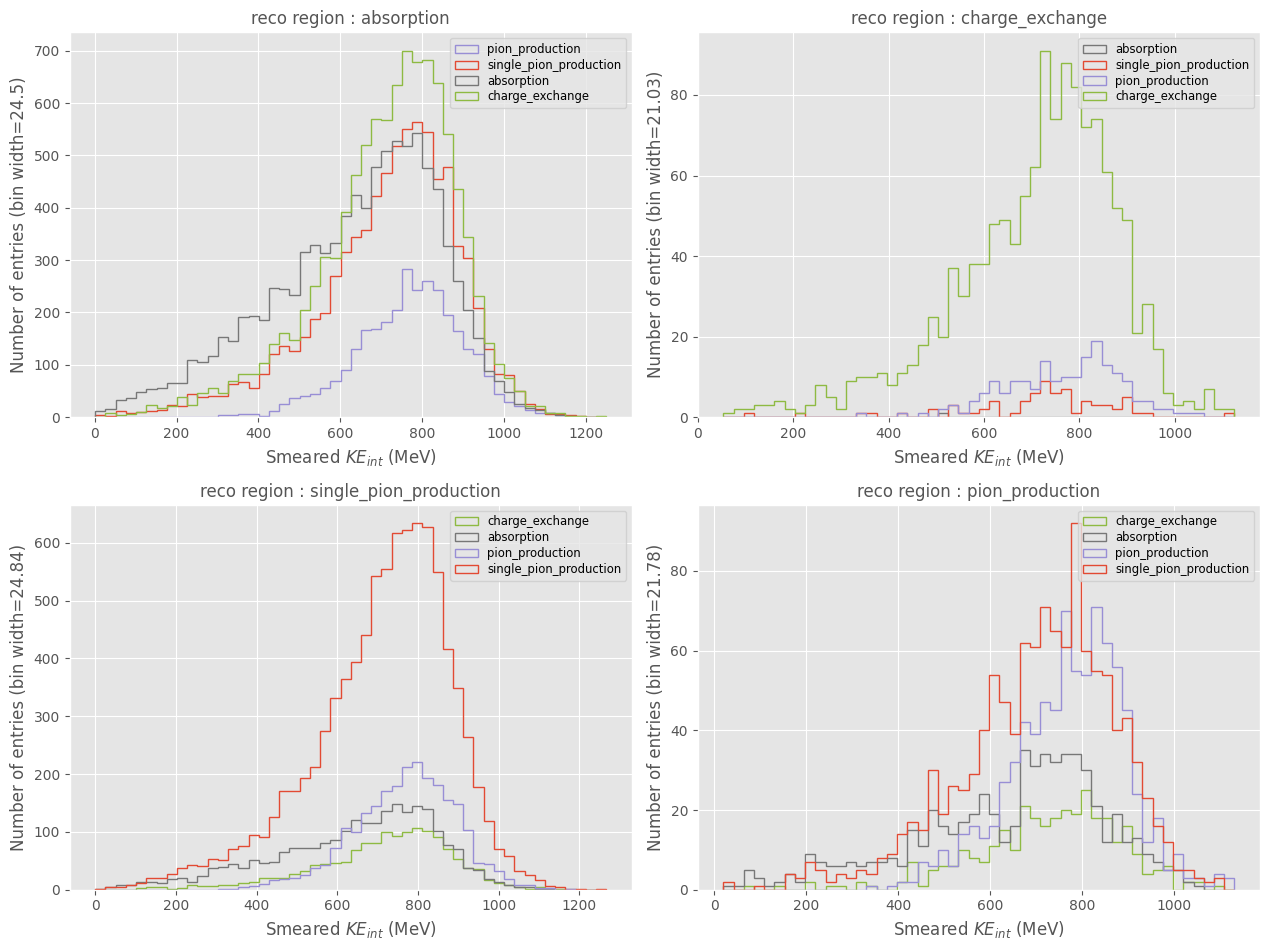

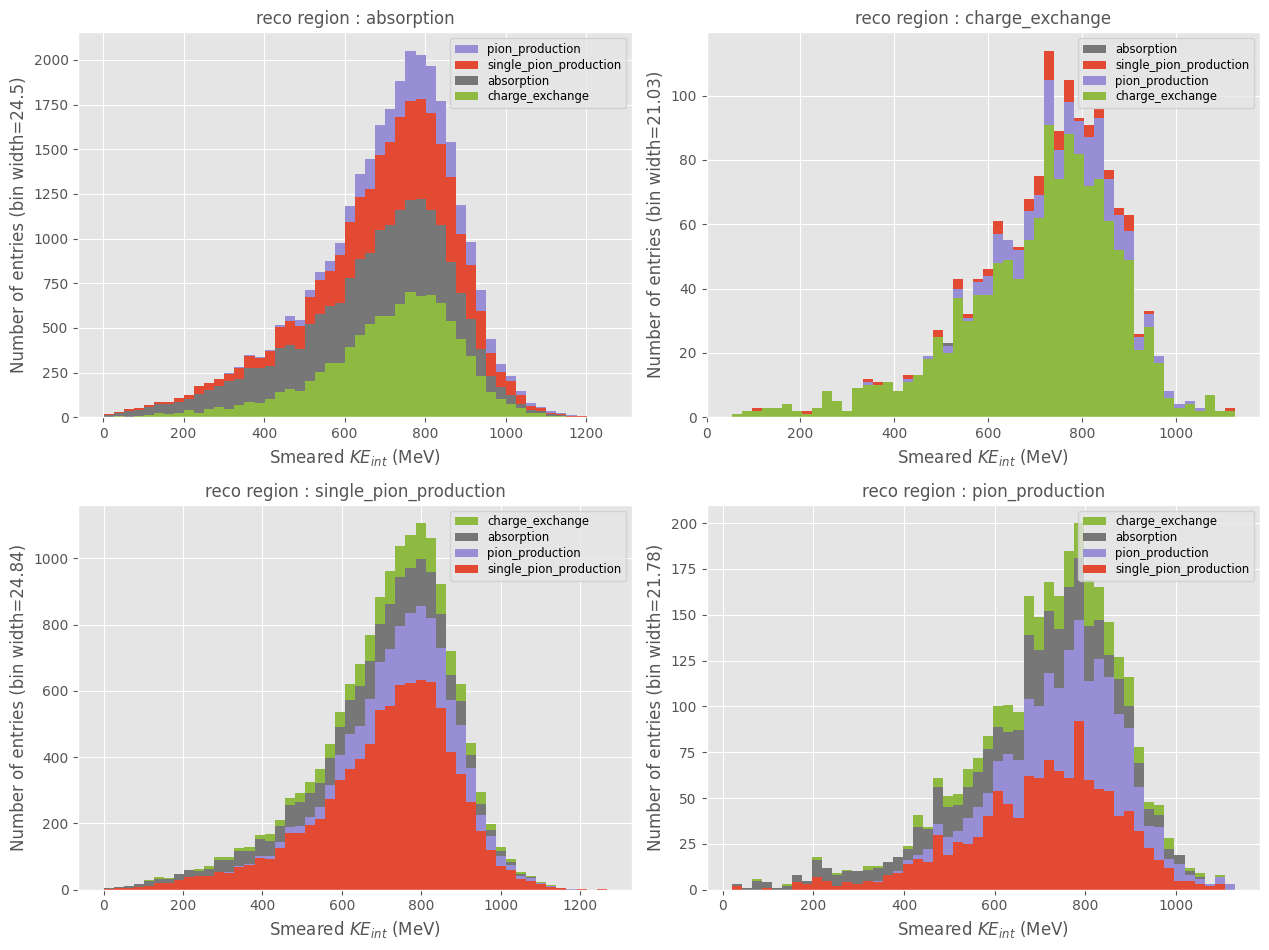

In [21]:
toy_alt_pdf = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(scales))), smearing = True)
cross_section.Toy.PlotObservablesInRegions(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.reco_regions, toy_alt_pdf.truth_regions, "Smeared $KE_{int}$ (MeV)")
cross_section.Toy.PlotObservablesInRegions(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.reco_regions, toy_alt_pdf.truth_regions, "Smeared $KE_{int}$ (MeV)", stacked = True, histtype = "stepfilled")

## Compare shapes

'Simulate' executed in 4.9744s

'Smearing' executed in 0.0757s

'BeamSelectionEfficiency' executed in 0.0029s

'GenerateRecoRegions' executed in 0.0437s

'main' executed in 5.1894s

'Simulate' executed in 4.8874s

'Smearing' executed in 0.0765s

'BeamSelectionEfficiency' executed in 0.0029s

'GenerateRecoRegions' executed in 0.0452s

'main' executed in 5.1033s

'Simulate' executed in 4.9931s

'Smearing' executed in 0.0770s

'BeamSelectionEfficiency' executed in 0.0028s

'GenerateRecoRegions' executed in 0.0445s

'main' executed in 5.2110s

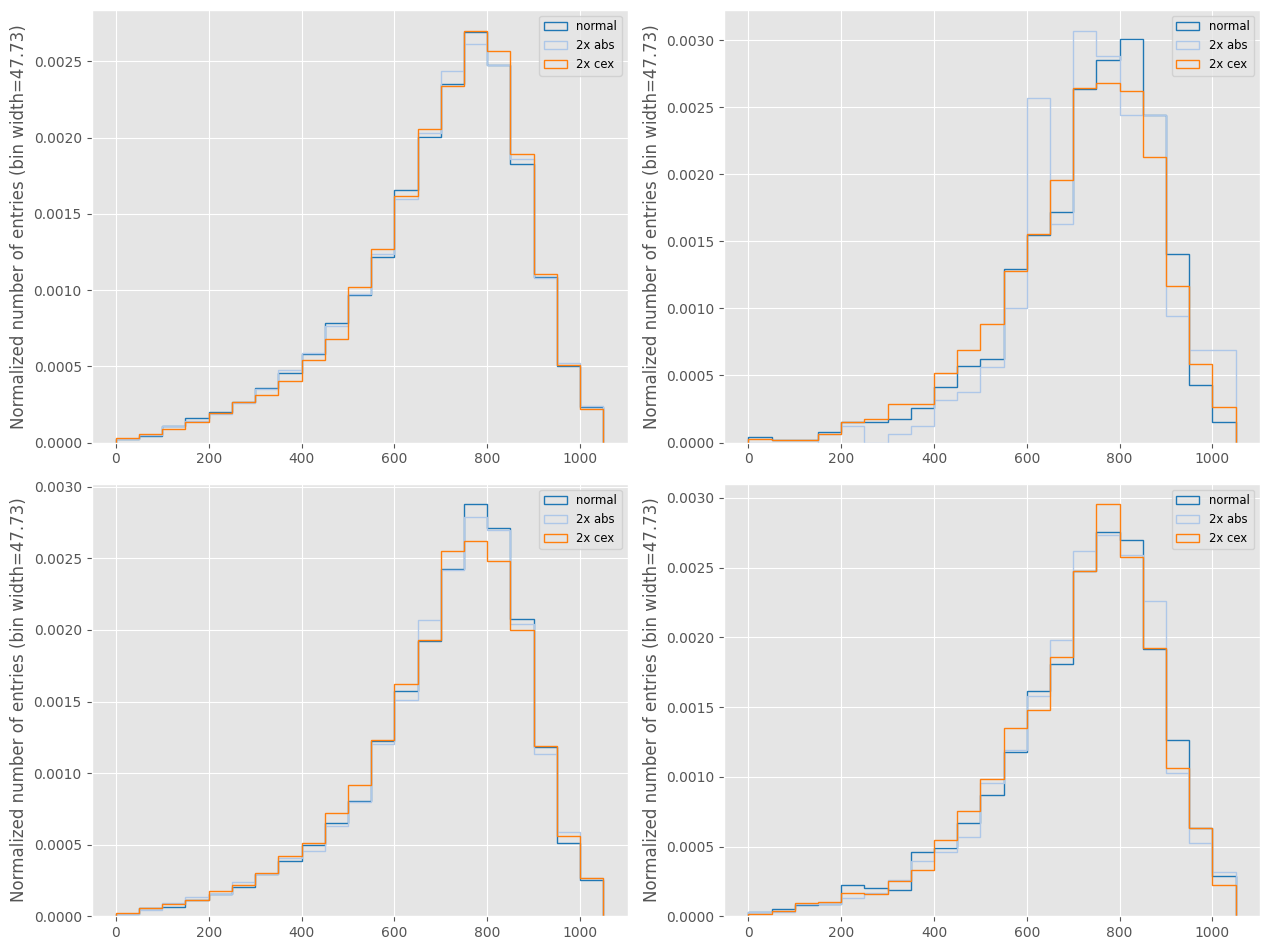

In [31]:
scales_original = {'absorption': 1, 'quasielastic': 1, 'charge_exchange': 1, 'double_charge_exchange': 1, 'pion_production': 1}
scales_abs = {'absorption': 10, 'quasielastic': 1, 'charge_exchange': 1, 'double_charge_exchange': 1, 'pion_production': 1}
scales_cex = {'absorption': 1, 'quasielastic': 1, 'charge_exchange': 10, 'double_charge_exchange': 1, 'pion_production': 1}

toys = [cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(CreateConfig(s))), smearing = True) for s in [scales_original, scales_abs, scales_cex]]
for _, r in Plots.IterMultiPlot(toy_input.reco_regions.columns): 
    data = [toy.df.KE_int_smeared[toy.reco_regions[r]] for toy in toys]
    Plots.PlotHistComparison(data, labels = ["normal", "2x abs", "2x cex"], bins = bins, newFigure = False)

## Fits for different rates

In [5]:
def PlotFitResults(results, true_counts, target : str, pdf : Plots.PlotBook = None):
    colours = {
        "absorption"      : "#777777",
        "charge_exchange" : "#8EBA42",
        "single_pion_production" : "#E24A33",
        "pion_production" : "#988ED5",
    }

    mu = []
    mu_err = []
    for result in results.values():
        mu.append(result.bestfit[0:4])
        mu_err.append(result.uncertainty[0:4])
    mu = np.array(mu)
    mu_err = np.array(mu_err)

    xlabel = f"{target} scale factor"

    # Plot the fit value for each scale factor 
    plt.figure()
    for i in range(4):
        Plots.Plot(list(range(len(results))), mu[:, i], yerr = mu_err[:, i], newFigure = False, label = f"$\mu_{i}$", marker = "o", ylabel = "fit value", color = list(colours.values())[i])
    Plots.plt.xticks(ticks = list(range(len(results))), labels = results.keys())
    Plots.plt.xlabel(xlabel)
    if pdf: pdf.Save()

    # same as above, in separate plots
    for i in Plots.MultiPlot(4):
        Plots.Plot(list(range(len(results))), mu[:, i], yerr = mu_err[:, i], newFigure = False, label = f"$\mu_{i}$", marker = "o", xlabel = xlabel, ylabel = "fit value", color = list(colours.values())[i])
    Plots.plt.xticks(ticks = list(range(len(results))), labels = results.keys())
    if pdf: pdf.Save()

    true_counts_pred_res = {}
    true_counts_pred_res_err = {}
    for k, v in results.items():
        post_fit_pred = cross_section.cabinetry.model_utils.prediction(model, fit_results = v, label = "post-fit")
        true_counts_pred_res_err[k] = np.sum(post_fit_pred.total_stdev_model_channels, 0)[:-1]
        true_counts_pred_res[k] = {toy_input.truth_region_labels[j] : int(np.sum([post_fit_pred.model_yields[i][j] for i in range(len(toy_input.reco_region_labels))])) - true_counts[k][toy_input.truth_region_labels[j]] for j in range(len(toy_input.truth_region_labels))}

    true_counts = pd.DataFrame(true_counts)
    true_counts_pred_res = pd.DataFrame(true_counts_pred_res)
    true_counts_pred_res_err = pd.DataFrame(true_counts_pred_res_err, index = true_counts_pred_res.index)

    # plot true process residual
    for n, i in Plots.IterMultiPlot(true_counts.index):
        Plots.Plot(true_counts_pred_res.columns, true_counts_pred_res.loc[i], yerr = true_counts_pred_res_err.loc[i], title = f"$\mu_{n}$", xlabel = xlabel, ylabel = "predicted counts - true counts", linestyle = "", marker = "o", color = list(colours.values())[n], newFigure = False)
        plt.axhline(0, color = "black", linestyle = "--")
    if pdf: pdf.Save()


def ModifiedRateTest(scales : dict, pdf_name : str = None, pulls : bool = False):
    if pdf_name is not None:
        pdf = Plots.PlotBook(pdf_name)
        pdf.open()
    else:
        pdf = None

    config = CreateConfig(scales)

    toy_alt_pdf = cross_section.Toy(df = cex_toy_generator.main(cex_toy_generator.ResolveConfig(config)), smearing = True)
    cross_section.Toy.PlotObservablesInRegions(toy_alt_pdf.df.KE_int_smeared, toy_alt_pdf.reco_regions, toy_alt_pdf.truth_regions, "Smeared $KE_{int}$ (MeV)")
    if pdf_name is not None: pdf.Save()
    result = RegionFitStudy(toy_alt_pdf, model, bins, pdf = pdf)
    if pdf_name is not None: pdf.close()

    mask = (toy_alt_pdf.df.KE_int_smeared > 0) & (toy_alt_pdf.df.KE_int_smeared < 1050) & (toy_alt_pdf.df.inclusive_process != "decay")

    true_process_counts = {v : np.sum(toy_alt_pdf.truth_regions[v] & mask, 0) for v in toy_alt_pdf.truth_regions.columns}

    expected_mus = [sum(toy_alt_pdf.truth_regions[r]) / sum(toy_input.truth_regions[r]) for r in toy_alt_pdf.truth_regions]

    if pdf_name is not None: Plots.plt.close("all")
    return result, true_process_counts, expected_mus, None


pdf test/region_fit_tests/pip/vary_pip_1.pdf has been opened


'Simulate' executed in 12.0256s

'Smearing' executed in 0.1878s

'BeamSelectionEfficiency' executed in 0.0068s

'GenerateRecoRegions' executed in 0.1230s

'main' executed in 12.5514s

'CreateObservedInputData' executed in 0.0079s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

total_count_actual, total_count, total_count_err=(50069, 50068.999484480475, 712.707148889092)

$mu_0$    $mu_1$    $mu_2$    $mu_3$
value  0.004852  0.005176  0.005213  0.005068
error  0.000150  0.000241  0.000150  0.000370

pdf test/region_fit_tests/pip/vary_pip_1.pdf has been closed
pdf test/region_fit_tests/pip/vary_pip_1.1.pdf has been opened


'Simulate' executed in 10.7102s

'Smearing' executed in 0.1716s

'BeamSelectionEfficiency' executed in 0.0073s

'GenerateRecoRegions' executed in 0.0978s

'main' executed in 11.1791s

'CreateObservedInputData' executed in 0.0078s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

total_count_actual, total_count, total_count_err=(50059, 50059.122050291524, 710.9131018131362)

$mu_0$    $mu_1$    $mu_2$    $mu_3$
value  0.005131  0.004796  0.004953  0.005627
error  0.000149  0.000238  0.000150  0.000372

pdf test/region_fit_tests/pip/vary_pip_1.1.pdf has been closed
pdf test/region_fit_tests/pip/vary_pip_1.25.pdf has been opened


'Simulate' executed in 7.0972s

'Smearing' executed in 0.1088s

'BeamSelectionEfficiency' executed in 0.0041s

'GenerateRecoRegions' executed in 0.0755s

'main' executed in 7.4151s

'CreateObservedInputData' executed in 0.0063s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

total_count_actual, total_count, total_count_err=(50039, 50038.98760427577, 707.4916016040522)

$mu_0$    $mu_1$    $mu_2$    $mu_3$
value  0.005025  0.004692  0.005100  0.005509
error  0.000148  0.000236  0.000149  0.000370

pdf test/region_fit_tests/pip/vary_pip_1.25.pdf has been closed
pdf test/region_fit_tests/pip/vary_pip_1.5.pdf has been opened


'Simulate' executed in 7.4030s

'Smearing' executed in 0.1304s

'BeamSelectionEfficiency' executed in 0.0042s

'GenerateRecoRegions' executed in 0.0920s

'main' executed in 7.7758s

'CreateObservedInputData' executed in 0.0077s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

total_count_actual, total_count, total_count_err=(50046, 50046.01609562464, 704.3692428079273)

$mu_0$    $mu_1$    $mu_2$    $mu_3$
value  0.005098  0.004523  0.004938  0.005989
error  0.000147  0.000233  0.000149  0.000369

pdf test/region_fit_tests/pip/vary_pip_1.5.pdf has been closed
pdf test/region_fit_tests/pip/vary_pip_1.75.pdf has been opened


'Simulate' executed in 9.4549s

'Smearing' executed in 0.1242s

'BeamSelectionEfficiency' executed in 0.0045s

'GenerateRecoRegions' executed in 0.0758s

'main' executed in 9.7972s

'CreateObservedInputData' executed in 0.0089s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

total_count_actual, total_count, total_count_err=(50028, 50028.01124675709, 694.5303645963245)

$mu_0$    $mu_1$    $mu_2$    $mu_3$
value  0.005214  0.004205  0.004669  0.006810
error  0.000145  0.000227  0.000147  0.000364

pdf test/region_fit_tests/pip/vary_pip_1.75.pdf has been closed
pdf test/region_fit_tests/pip/vary_pip_2.pdf has been opened


'Simulate' executed in 9.1910s

'Smearing' executed in 0.1261s

'BeamSelectionEfficiency' executed in 0.0051s

'GenerateRecoRegions' executed in 0.0740s

'main' executed in 9.5542s

'CreateObservedInputData' executed in 0.0076s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

total_count_actual, total_count, total_count_err=(49993, 49992.97890390167, 696.0813382638252)

$mu_0$    $mu_1$    $mu_2$    $mu_3$
value  0.005227  0.004261  0.004536  0.007073
error  0.000145  0.000229  0.000147  0.000366

pdf test/region_fit_tests/pip/vary_pip_2.pdf has been closed
pdf test/region_fit_tests/pip/fit_results.pdf has been opened
pdf test/region_fit_tests/pip/fit_results.pdf has been closed


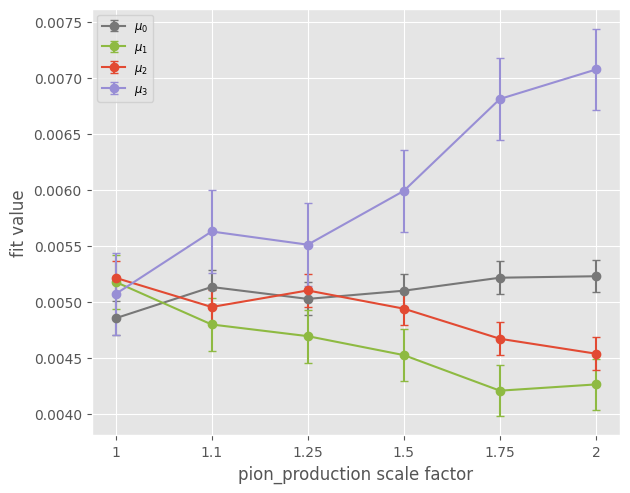

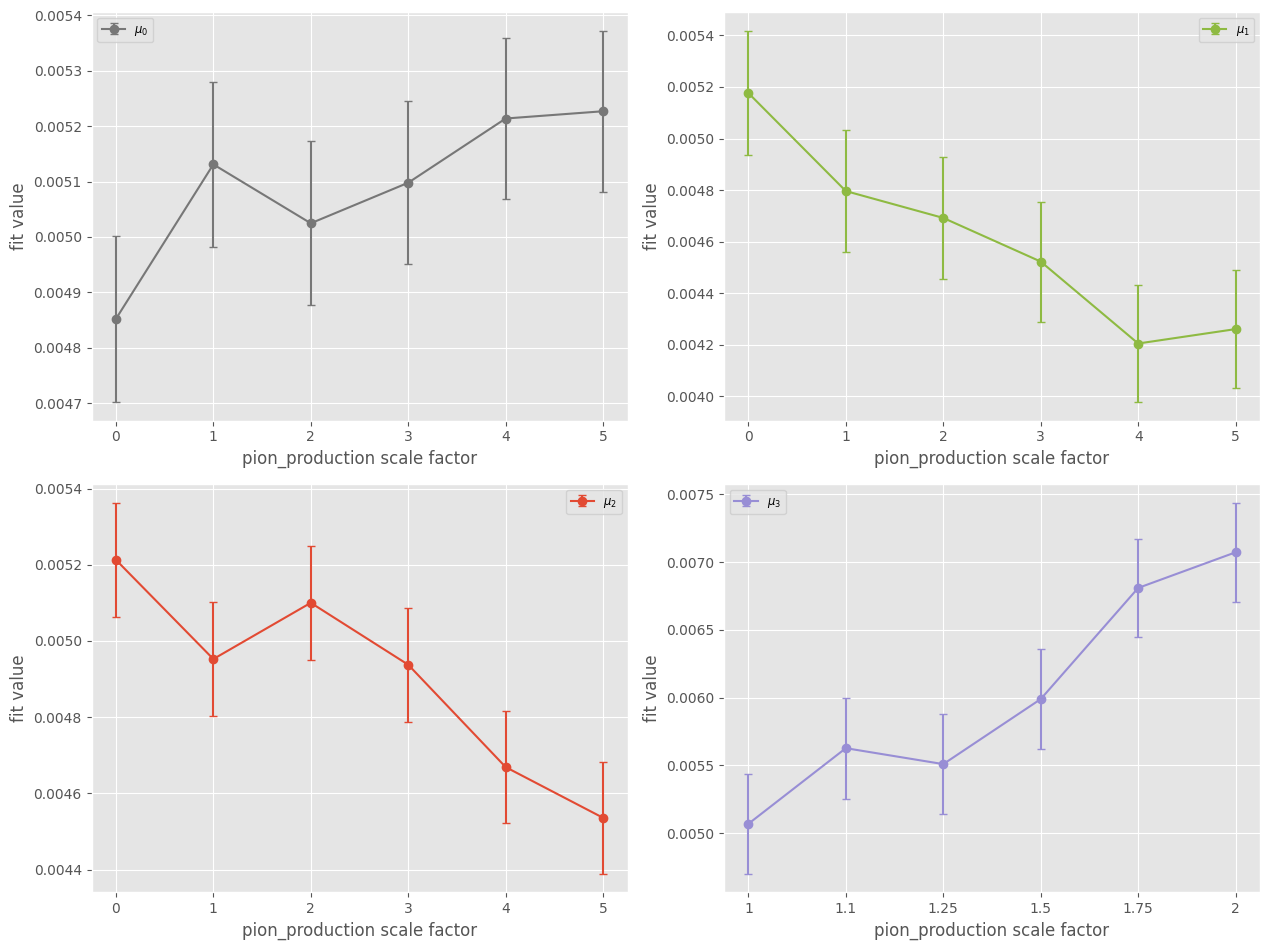

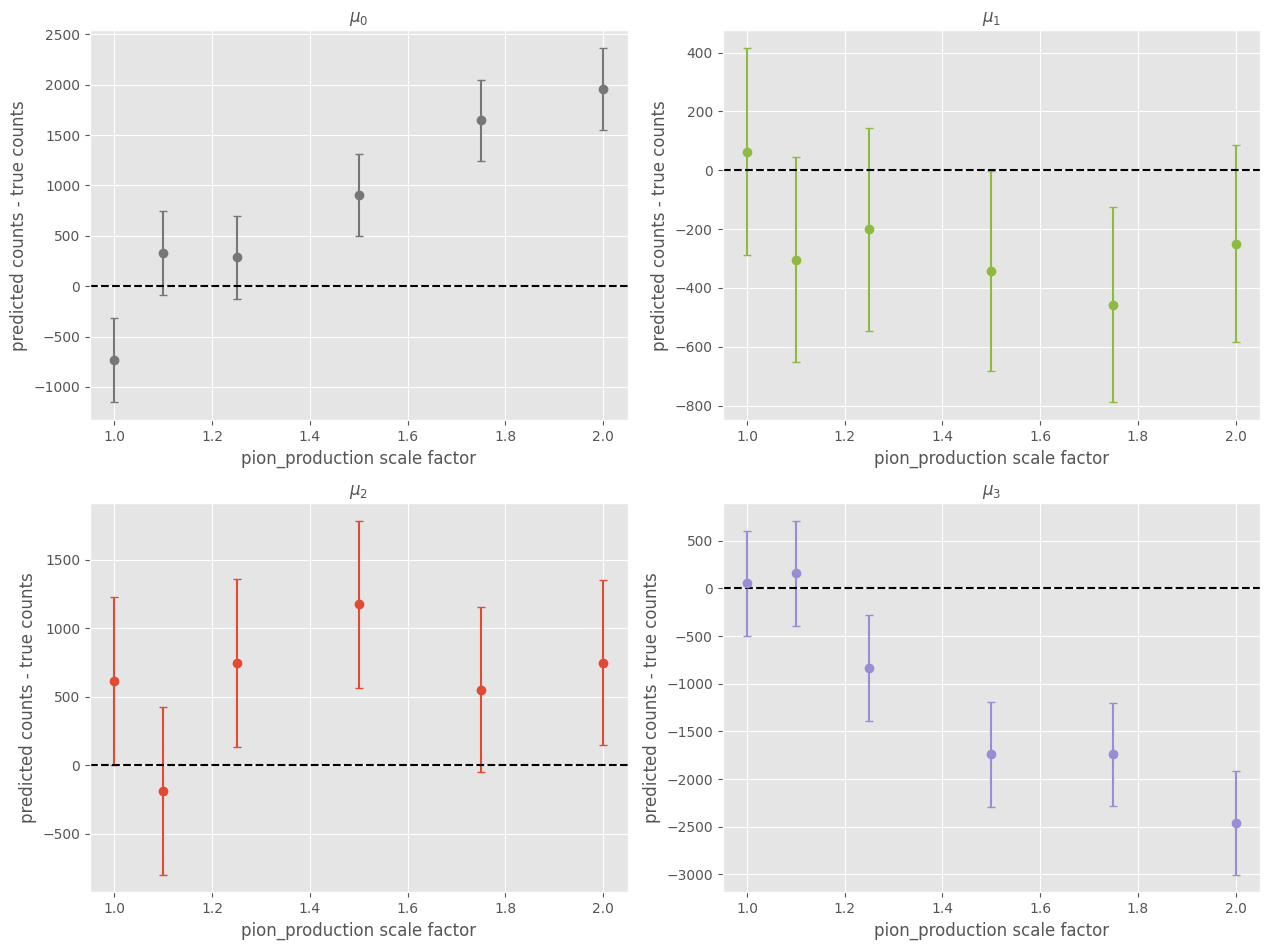

In [14]:
scales = {
    'absorption': 1,
    'quasielastic': 1,
    'charge_exchange': 1,
    'double_charge_exchange': 1,
    'pion_production': 1
    }

results = {}
true_counts = {}
pulls = {}
expected_mus = {}
target = "pion_production"
dire = "test/region_fit_tests/pip/"
for i in [1, 1.1, 1.25, 1.5, 1.75, 2]:
    scales[target] = i
    results[i], true_counts[i], expected_mus[i], pulls[i], = ModifiedRateTest(scales, f"{dire}vary_pip_{i}.pdf", pulls = False)

with Plots.PlotBook(f"{dire}fit_results.pdf") as pdf:
    PlotFitResults(results, true_counts, target, pdf)

In [73]:
scales_original = {'absorption': 1, 'quasielastic': 1, 'charge_exchange': 1, 'double_charge_exchange': 2, 'pion_production': 1}
pulls = CalculatePulls(100, CreateConfig(scales_original), model, bins),

'CreateObservedInputData' executed in 0.0053s

model.config.suggested_init()=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [75]:
# pulls = np.array([p for p in pulls if len(p) == 4])
with Plots.PlotBook("test/region_fit_tests/dcex/pulls.pdf") as pdf:
    StudyPulls(pulls)
    pdf.Save()

pdf test/region_fit_tests/dcex/pulls.pdf has been opened
pdf test/region_fit_tests/dcex/pulls.pdf has been closed


AttributeError: 'tuple' object has no attribute 'shape'

In [ ]:
cross_section.SaveSelection("var_abs_pulls.dill", pulls)
fits = cross_section.LoadSelectionFile("var_abs_pulls.dill")
for k, v in fits.items():
    print(f"scale factor: {k}")
    print(expected_mus[k])
    # print(fits)
    StudyPulls(v, 0.005)

# ABCD Method

In [ ]:
def ABCDModel(samples : np.array):
    channels = [
        {
            "name": f"channel_0",
            "samples":[
                {
                    "name" : f"sig_A",
                    "data" : samples[0][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_A", 'type': 'shapesys', 'data': np.sqrt(samples[0][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_A",
                    "data" : samples[0][1].tolist(),
                    "modifiers" : [
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_A", 'type': 'shapesys', 'data': np.sqrt(samples[0][1]).astype(int).tolist()}
                        ]
                },

            ]
        },
        {
            "name": f"channel_1",
            "samples":[
                {
                    "name" : f"sig_B",
                    "data" : samples[1][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_B", 'type': 'shapesys', 'data': np.sqrt(samples[1][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_B",
                    "data" : samples[1][1].tolist(),
                    "modifiers" : [
                        {'name': f"alpha", 'type': 'normfactor', 'data': None},
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_B", 'type': 'shapesys', 'data': np.sqrt(samples[1][1]).astype(int).tolist()}
                        ]
                }
            ]
        },
        {
            "name": f"channel_2",
            "samples":[
                {
                    "name" : f"sig_C",
                    "data" : samples[2][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_C", 'type': 'shapesys', 'data': np.sqrt(samples[2][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_C",
                    "data" : samples[2][1].tolist(),
                    "modifiers" : [
                        {'name': f"beta", 'type': 'normfactor', 'data': None},
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_C", 'type': 'shapesys', 'data': np.sqrt(samples[2][1]).astype(int).tolist()}
                        ]
                }
            ]
        },
        {
            "name": f"channel_3",
            "samples":[
                {
                    "name" : f"sig_D",
                    "data" : samples[3][0].tolist(),
                    "modifiers" : [
                        {'name': f"mu_sig", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_sig_D", 'type': 'shapesys', 'data': np.sqrt(samples[3][0]).astype(int).tolist()}
                        ]
                },
                {
                    "name" : f"bkg_D",
                    "data" : samples[3][1].tolist(),
                    "modifiers" : [
                        {'name': f"alpha", 'type': 'normfactor', 'data': None},
                        {'name': f"beta", 'type': 'normfactor', 'data': None},
                        {'name': f"mu_bkg", 'type': 'normfactor', 'data': None},
                        {'name': f"pois_err_bkg_D", 'type': 'shapesys', 'data': np.sqrt(samples[3][1]).astype(int).tolist()}
                        ]
                }
            ]
        },
    ]
    spec = {"channels" : channels}
    model = cross_section.pyhf.Model(spec, poi_name = "mu_sig")
    return model

def CreateModelInputDataABCD(toy : cross_section.Toy, signal : str, bins : np.array):
    samples_binned = []
    for r in toy.reco_regions:
        samples = []
        for t in toy.truth_regions:
            if t == "charge_exchange":
                samples.append(np.histogram(toy.df.KE_int_smeared[toy.reco_regions[r] & toy.truth_regions[t]], bins)[0])
                samples.append(np.histogram(toy.df.KE_int_smeared[toy.reco_regions[r] & ~toy.truth_regions[t]], bins)[0])
        samples_binned.append(samples)
    return samples_binned


def ABCD_MLEScan(toy, model, bins, poi_ind : int, params : np.array):
    observations = cross_section.BackgroundFit.GenerateObservations(CreateObservedInputData(toy, bins, toy.reco_regions), model)
    # params = np.array(params)
    p = np.linspace(0, 2, 101)
    nll = []
    for i in p:
        params_new = np.array(params)
        params_new[poi_ind] = i
        nll.append(-2 * model.logpdf(params_new, observations)[0])

    Plots.Plot(p, nll, xlabel = model.config.par_names[poi_ind], ylabel = "$-2\ln(L)$", newFigure = False)
    min_ind = np.argmin(nll)
    Plots.Plot(p[min_ind], nll[min_ind], marker = "x", newFigure = False, label = f"minimum | {model.config.par_names[poi_ind]}={p[min_ind]:.3g}, $-2\ln(L)$={nll[min_ind]:.3g}", color = "black")


def ABCD_Study(toy_model : cross_section.Toy, toy_obs : cross_section.Toy, pdf : Plots.PlotBook):
    bins = np.linspace(0, 1050, 22)
    model_alt = ABCDModel(CreateModelInputDataABCD(toy_model, bins))
    observed = cross_section.BackgroundFit.GenerateObservations(CreateObservedInputData(toy_obs, bins, toy_obs.reco_regions), model_alt)
    result = cross_section.BackgroundFit.Fit(observed, model_alt, False)

    prefit_pred = cross_section.cabinetry.model_utils.prediction(model_alt)
    postfit_pred = cross_section.cabinetry.model_utils.prediction(model_alt, fit_results = result)
    print(result)

    true_counts = cross_section.Toy.ComputeCounts(toy_obs.truth_regions, toy_obs.reco_regions)
    cex_toy_parameters.PlotCorrelationMatrix(true_counts, toy_obs.truth_region_labels, toy_obs.reco_region_labels)
    pdf.Save()

    titles = toy_model.reco_region_labels

    x = (bins[1:] + bins[:-1]) / 2
    for n, (i, j) in Plots.IterMultiPlot(list(zip(prefit_pred.model_yields, postfit_pred.model_yields))):
        Plots.Plot(x, i[4 + n], label = "prefit signal", xlabel = "smeared $KE_{int}$(MeV)", title = titles[n].replace("_", " "), newFigure = False)
        Plots.Plot(x, i[n], label = "prefit bkg", newFigure = False)

        Plots.Plot(x, j[4 + n], label = "postfit signal", newFigure = False)
        Plots.Plot(x, j[n], label = "postfit bkg", newFigure = False)
    pdf.Save()

    actual_yield = CreateModelInputDataABCD(toy_obs, bins)
    for n, (i, j, k) in Plots.IterMultiPlot(list(zip(actual_yield, postfit_pred.model_yields, postfit_pred.total_stdev_model_bins))):
        Plots.Plot(x, i[0], label = "actual signal", xlabel = "smeared $KE_{int}$(MeV)", title = titles[n], newFigure = False)
        Plots.Plot(x, i[1], label = "actual bkg", newFigure = False)

        Plots.Plot(x, j[4 + n], yerr = k[4 + n], label = "postfit signal", newFigure = False)
        Plots.Plot(x, j[n], yerr = k[n], label = "postfit bkg", newFigure = False)
    pdf.Save()

    for i in Plots.MultiPlot(4):
        ABCD_MLEScan(toy_obs, model_alt, bins, i, model_alt.config.suggested_init())
    pdf.Save()
    return

In [ ]:
pdf_valid = Plots.PlotBook("toy_ABCD_valid.pdf", True)
ABCD_Study(toy_input, toy_input, pdf_valid)
pdf_valid.close()

In [ ]:
pdf_vary = Plots.PlotBook("toy_ABCD_vary_regions.pdf", True)
ABCD_Study(toy_input, toy_alt, pdf_vary)
pdf_vary.close()